In [28]:
from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} 
    h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render 
    h1 { font-size: 30px; } h1 {padding: 10px 12px;font-style: bold; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render 
    h3 { padding: 10px 12px; background-color: #16bedb; position: static; color: #ffffff; font-size: 20px;} 
    h4 {padding: 8px 20px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #57fa05; color: #ffffff; font-size: 18px;  border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
    <script> code_show=true; function code_toggle() {if (code_show){$('div.input').hide();} else {$('div.input').show();} code_show = !code_show} $( document ).ready(code_toggle);</script>
    <form action="javascript:code_toggle()"><input type="submit" value="Hide/show all code."></form>
''')

# Sydney Liveability Analysis

## Group - 5  F10Adv-01 : Pratul Singh Raghava & Amanda Walpitage

This Jupyter Notebook contains the code and processes followed to calculate a **Liveability score** for each SA2 Area in Greater Sydney and further analysis of Inner Sydney suburbs through the integration of additional datasets. The results of this analysis have further been compared to parameters like Median Rent and Median Income of each neighbourhood in an attempt to figure out their correlation with the analysis results. This notebook also contains the analysis by an Unsupervised Machine Learning Algorithm and the comparison of its results with the tradional methods used before.

### Importing Modules

Before we proceed with the analysis, we must first import all the necessary modules required to perform the analysis.

In [29]:
import pandas as pd
import numpy as np
import geopandas as gpd
import json
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.manifold import TSNE

# TASK - 1

### Importing Datasets

#### Importing Spatial Data

We import the spatial data from .shp files and store them in GeoPandas DataFrames, which are just like Pandas DataFrames, but with support for Geo-Spatial data.

In [30]:
# Importing the ABS SA2 Shape Data
sa2_data = gpd.read_file("SA2_2016_AUST/SA2_2016_AUST.shp")

# Importing the shape data of theft ’hotspots’ in NSW 
break_and_enter = gpd.read_file("break_and_enter/BreakEnterDwelling_JanToDec2021.shp")

# Importing the shape data for future Government schools catchments
school_catchments_future = gpd.read_file("school_catchments/catchments_future.shp")

# Importing the shape data for primary Government schools catchments
school_catchments_primary = gpd.read_file("school_catchments/catchments_primary.shp")

# Importing the shape data for secondary Government schools catchments
school_catchments_secondary = gpd.read_file("school_catchments/catchments_secondary.shp")

#### Importing Non-Spatial CSV Data

We import the non-spatial data from .csv files and store them in Pandas DataFrames.

In [31]:
# Importing the Census data on neighbourhoods(SA2-level areas)
neighbourhoods = pd.read_csv('Neighbourhoods.csv')

# Importing the Business statistics per SA2-area
BusinessStats = pd.read_csv('BusinessStats.csv')

#### Importing Spatial GeoJSON Data

Now, we import the spatial data from the additional datasets
[Playgrounds](https://data.cityofsydney.nsw.gov.au/datasets/cityofsydney::playgrounds/about)
&
[Lights](https://data.cityofsydney.nsw.gov.au/datasets/cityofsydney::lights/about)
downloaded from the [
City of Sydney Data hub](https://data.cityofsydney.nsw.gov.au/).

In [32]:
Playgrounds_json = json.load(open('Playgrounds.geojson'))

Playgrounds_DataFrame = pd.DataFrame(Playgrounds_json["features"])
Playgrounds_pandas_data=[]
for index, row in Playgrounds_DataFrame.iterrows():
    append_row = [row["geometry"]["coordinates"][0],row["geometry"]["coordinates"][1],row["properties"]["Name"]]
    Playgrounds_pandas_data.append(append_row)
    
Playgrounds = pd.DataFrame(Playgrounds_pandas_data, columns = ['X', 'Y','Name'])
Playgrounds['geom'] = gpd.points_from_xy(Playgrounds.X, Playgrounds.Y)  # creating the geometry column
Playgrounds = Playgrounds.drop(columns=['X', 'Y'])  # removing the old latitude/longitude fields

In [33]:
Lights_json = json.load(open('Lights.geojson'))
Lights_DataFrame = pd.DataFrame(Lights_json["features"])
Lights_pandas_data=[]
for index, row in Lights_DataFrame.iterrows():
    append_row = [row["geometry"]["coordinates"][0],row["geometry"]["coordinates"][1],row["properties"]["Location"]]
    Lights_pandas_data.append(append_row)
    
Lights = pd.DataFrame(Lights_pandas_data, columns = ['X', 'Y','Location'])
Lights['geom'] = gpd.points_from_xy(Lights.X, Lights.Y)  # creating the geometry column
Lights = Lights.drop(columns=['X', 'Y'])  # removing the old latitude/longitude fields

### Cleaning the Datasets

We clean the **sa2_data** dataset by dropping those rows where either the locations are :

a) `No usual address` - people with no fixed place of abode, or 

b) `Migratory - Offshore - Shipping` - people who are in transit (Migratory) or on oil rigs and drilling platforms (Offshore) or on board vessels (Shipping).

In [34]:
sa2_data = sa2_data.drop(sa2_data[(sa2_data['SA4_NAME16'].str.contains("No usual address", case=False)) |
                                  (sa2_data['SA4_NAME16'].str.contains("Migratory - Offshore - Shipping", case=False)) |
                         sa2_data['SA3_NAME16'].str.contains("No usual address", case=False) |
                         sa2_data['SA3_NAME16'].str.contains("Migratory - Offshore - Shipping", case=False) |
                         sa2_data['SA2_NAME16'].str.contains("No usual address", case=False) | 
                         sa2_data['SA2_NAME16'].str.contains("Migratory - Offshore - Shipping", case=False) | 
                         sa2_data['GCC_NAME16'].str.contains("No usual address", case=False) | 
                         sa2_data['GCC_NAME16'].str.contains("Migratory - Offshore - Shipping", case=False) |
                         sa2_data['GCC_NAME16'].str.contains("Rest of", case=False)].index
                        )

For our Task-2 analysis, we filter our data to only contain rows with their region as **'Greater Sydney'**.

In [35]:
sa2_data = sa2_data[sa2_data['GCC_NAME16']=='Greater Sydney'] 

Now, we clean the **neighbourhoods** dataset and get rid of the rows where the young population value is zero or null, to avoid ZeroDivisionError and other potential errors later on.

In [36]:
neighbourhoods = neighbourhoods.drop(neighbourhoods[(neighbourhoods['population'].isnull()) | 
                                      (neighbourhoods['0-4'].isnull()) | 
                                      (neighbourhoods['5-9'].isnull()) | 
                                      (neighbourhoods['10-14'].isnull() )| 
                                      (neighbourhoods['15-19'].isnull())].index)
neighbourhoods = neighbourhoods.drop(neighbourhoods[(neighbourhoods['0-4']+neighbourhoods['5-9']+neighbourhoods['10-14']+neighbourhoods['15-19'])<=0].index)

# neighbourhoods = neighbourhoods.drop(neighbourhoods[neighbourhoods['population']<=0].index)

We find that the `population` column in the **neighbourhoods** dataset contains values stored as String datatypes. Since we require the population values to be of integer datatypes for our analysis, we iterate through these values and explicitly convert them from Strings to Integers.

In [37]:
for index, row in neighbourhoods.iterrows():
    old_value = row['population']
    old_value_split = str(row['population']).split(",")
    new_value = ""
    for i in old_value_split :
        new_value = new_value+i
    neighbourhoods['population'] = neighbourhoods['population'].replace([old_value],int(new_value))

### Connecting to PostgreSQL

 Now, we create a helper function to establish a connection to the servers. The `Credentials.json` file should be stored in the same directory as the notebook.

In [38]:
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

Running this code successfully connects to the PostgreSQL database.

In [39]:
db, conn = pgconnect(credentials)

Connected successfully.


Running the below query confirms that POSTGIS which is used for geographical operations is correctly configured.

In [40]:
query(conn, "select PostGIS_Version()")

,postgis_version
0,3.0 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


### SRID Transformations

Ensuring the spatial data types from GeoPandas are the same as those expected by PostGIS requires conversion to the **Well-Known Text (WKT)** format, as an intermediate step. This can be done using the `geoalchemy2` library, to convert from the `shapely` types in GeoPandas to the WKT format in PostGIS.

We'll also be sure to specify the **Spatial Reference Identifier (SRID)** - in this case 4326, to represent the [WGS84 world geodetic coordinate system](https://en.wikipedia.org/wiki/World_Geodetic_System) used by our datasets. The following code simply converts the 'geom' column of the **Lights** & **Playgrounds** dataframe accordingly.

In [41]:
srid = 4326
Playgrounds['geom'] = Playgrounds['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
Lights['geom'] = Lights['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))

Converting the polygons in our **sa2_data**, **break_and_enter**, **school_catchments_primary** , **school_catchments_secondary** & **school_catchments_future** dataframes requires more work. We'll first ensure they're all represented as multipolygons (of which polygons are a subset), and then conduct the same WKT conversion, all using a simple helper function.Then we converts the 'geom' column of the  dataframe accordingly.

In [42]:
def create_wkt_element(geom, srid):
    if geom!=None :
        if geom.geom_type == 'Polygon':
            geom = MultiPolygon([geom])
        return WKTElement(geom.wkt, srid)

sa2_data_og = sa2_data.copy()  # creating a copy of the original for later
sa2_data['geom'] = sa2_data['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
sa2_data = sa2_data.drop(columns="geometry")  # deleting the old copy

break_and_enter['geom'] = break_and_enter['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
break_and_enter = break_and_enter.drop(columns="geometry")  # deleting the old copy

school_catchments_future['geom'] = school_catchments_future['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
school_catchments_future = school_catchments_future.drop(columns="geometry")  # deleting the old copy

school_catchments_primary['geom'] = school_catchments_primary['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
school_catchments_primary = school_catchments_primary.drop(columns="geometry")  # deleting the old copy

school_catchments_secondary['geom'] = school_catchments_secondary['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
school_catchments_secondary = school_catchments_secondary.drop(columns="geometry")  # deleting the old copy

We reduce our dataframes only to contain the variables we are interested in the analysis.

In [43]:
sa2_data = sa2_data[['SA2_MAIN16', 'SA2_NAME16','SA3_NAME16','AREASQKM16','geom']].copy()
break_and_enter = break_and_enter[['OBJECTID', 'Density','ORIG_FID','Shape_Area','geom']].copy()
school_catchments_future = school_catchments_future[['USE_ID','CATCH_TYPE', 'USE_DESC','geom']].copy()
school_catchments_primary = school_catchments_primary[['USE_ID', 'USE_DESC','geom']].copy()
school_catchments_secondary = school_catchments_secondary[['USE_ID', 'USE_DESC','geom']].copy()
neighbourhoods = neighbourhoods[['area_id','land_area','population', 'number_of_dwellings','number_of_businesses','median_annual_household_income','avg_monthly_rent','0-4','5-9','10-14','15-19']].copy()
BusinessStats = BusinessStats[['area_id','number_of_businesses','accommodation_and_food_services','retail_trade','agriculture_forestry_and_fishing','health_care_and_social_assistance','public_administration_and_safety','transport_postal_and_warehousing']].copy()
Lights = Lights[['Location', 'geom']].copy()
Playgrounds = Playgrounds[['Name', 'geom']].copy()

### Creating SQL Tables

We create new tables in our schema so we can insert data into them to conduct our analysis.

In [44]:
# SQL Table for sa2_data
conn.execute("""
DROP TABLE IF EXISTS sa2_data;
CREATE TABLE sa2_data (
    "SA2_MAIN16" INTEGER PRIMARY KEY,
    "SA2_NAME16" VARCHAR(80),
    "SA3_NAME16" VARCHAR(80),
    "AREASQKM16" NUMERIC,
    "geom" GEOMETRY(MULTIPOLYGON,4326)
);"""
)

# SQL Table for neighbourhood Data
conn.execute("""
DROP TABLE IF EXISTS neighbourhood;
CREATE TABLE neighbourhood (
    "area_id" INTEGER PRIMARY KEY,
    "land_area" NUMERIC,
    "population" INTEGER,
    "number_of_dwellings" VARCHAR(80),
    "number_of_businesses" INTEGER,
    "median_annual_household_income" NUMERIC,
    "avg_monthly_rent" INTEGER,
    "0-4" INTEGER,
    "5-9" INTEGER,
    "10-14" INTEGER,
    "15-19" INTEGER
);"""
)

# SQL Table for break and enter Data
conn.execute("""
DROP TABLE IF EXISTS break_and_enter;
CREATE TABLE break_and_enter (
    "OBJECTID" INTEGER PRIMARY KEY,
    "Density" VARCHAR(80),
    "ORIG_FID" INTEGER,
    "Shape_Area" NUMERIC,
    "geom" GEOMETRY(MULTIPOLYGON,4326)
);"""
)

# SQL Table for school_catchments_future Data
conn.execute("""
DROP TABLE IF EXISTS school_catchments_future;
CREATE TABLE school_catchments_future (
    "USE_ID" INTEGER PRIMARY KEY, 
    "CATCH_TYPE" VARCHAR(80), 
    "USE_DESC" VARCHAR(80),
    "geom" GEOMETRY(MULTIPOLYGON,4326)
    
);"""
)

# SQL Table for school_catchments_primary Data
conn.execute("""
DROP TABLE IF EXISTS school_catchments_primary;
CREATE TABLE school_catchments_primary (
    "USE_ID" INTEGER PRIMARY KEY,
    "USE_DESC" VARCHAR(80),
    "geom" GEOMETRY(MULTIPOLYGON,4326)
    
);"""
)

# SQL Table for school_catchments_secondary Data
conn.execute("""
DROP TABLE IF EXISTS school_catchments_secondary;
CREATE TABLE school_catchments_secondary (
    "USE_ID" INTEGER PRIMARY KEY,
    "USE_DESC" VARCHAR(80),
    "geom" GEOMETRY(MULTIPOLYGON,4326)
    
);"""
)


# SQL Table for BusinessStats Data
conn.execute("""
DROP TABLE IF EXISTS businessstats;
CREATE TABLE businessstats (
    "area_id" INTEGER PRIMARY KEY,
    "number_of_businesses" INTEGER,
    "accommodation_and_food_services" INTEGER,
    "retail_trade" INTEGER,
    "agriculture_forestry_and_fishing" INTEGER,
    "health_care_and_social_assistance" INTEGER,
    "public_administration_and_safety" INTEGER,
    "transport_postal_and_warehousing" INTEGER
);"""
)

# SQL Table for Playgrounds Data
conn.execute("""
DROP TABLE IF EXISTS playgrounds;
CREATE TABLE playgrounds (
   "Name" VARCHAR(200),
   geom GEOMETRY(POINT, 4326)
);"""
)

# SQL Table for Lights Data
conn.execute("""
DROP TABLE IF EXISTS lights;
CREATE TABLE lights (
   "Location" VARCHAR(200),
   geom GEOMETRY(POINT, 4326)
);"""
)

We can run the below code to confirm that our SQL tables have been successfully created in the public schema of our PostgreSQL server.

In [45]:
from sqlalchemy import inspect
for table in inspect(db).get_table_names(schema='public') :
    print(table)

spatial_ref_sys
public.BusinessStats
BusinessStats
Lights
Playgrounds
cities
world
results
task2_results
task3_data
lights_database
playgrounds_database
task3_results
school_catchments_combined
sa2_data
neighbourhood
break_and_enter
school_catchments_future
school_catchments_primary
school_catchments_secondary
businessstats
playgrounds
lights


### Data Ingestion

Now, we load the data from the pandas DataFrames into their respective SQL tables. We specifically define the new datatype of our `geom` columns that is `Multipolygon`.

In [46]:
# Inserting the school datasets into SQL tables
school_catchments_future.to_sql("school_catchments_future", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
school_catchments_primary.to_sql("school_catchments_primary", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
school_catchments_secondary.to_sql("school_catchments_secondary", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

# Inserting the additional datasets into SQL tables
Lights.to_sql('lights', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
Playgrounds.to_sql('playgrounds', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})

# Inserting the other datasets into SQL tables
sa2_data.to_sql('sa2_data', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
neighbourhoods.to_sql('neighbourhood', conn, if_exists='append', index=False)
BusinessStats.to_sql('businessstats', conn, if_exists='append', index=False)
break_and_enter.to_sql("break_and_enter", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

### Reorganising SQL Tables

We combine the 3 different school catchment tables into a new table for the purpose of practicality. We can now get rid of the earlier tables since they are not of any further use.

In [47]:
SQL_Query_to_Combine_Tables="""
DROP TABLE IF EXISTS school_catchments_combined;
CREATE TABLE school_catchments_combined (
    "USE_ID" INTEGER,
    "USE_DESC" VARCHAR(80),
    "geom" GEOMETRY(MULTIPOLYGON,4326)
);

INSERT INTO school_catchments_combined("USE_ID","USE_DESC","geom")
    SELECT * FROM school_catchments_primary
    UNION ALL
    SELECT * FROM school_catchments_secondary
    UNION ALL
    SELECT "USE_ID","USE_DESC","geom" FROM school_catchments_future
    ;

DROP TABLE IF EXISTS school_catchments_primary;
DROP TABLE IF EXISTS school_catchments_secondary;
DROP TABLE IF EXISTS school_catchments_future;
"""

query(conn,SQL_Query_to_Combine_Tables)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


# TASK - 2

### Indexes

We create indices on our database tables to improve the run time and reduce the cost of executing queries.

As primary keys of our tables are indexes by default we don't need explicit indexes on those. As our data analysis summarises results by suburbs it is meaningful to create an index on "SA2_NAME16" in our sa2_data table (Note that the primary key of this table is "SA2_MAIN16").

In [48]:
# creating an index on sa2_name in sa2_data set
SQL_Query_to_Create_Index1 = """
CREATE INDEX sa2_name16_idx ON sa2_data("SA2_NAME16");
"""
query(conn,SQL_Query_to_Create_Index1)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [49]:
# creating an index on sa3_name in sa2_data set
SQL_Query_to_Create_Index2 = """
CREATE INDEX sa3_name16_idx ON sa2_data("SA3_NAME16");
"""
query(conn,SQL_Query_to_Create_Index2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


#### Spatial Indexes

Spatial indices reduce the time and cost of running spatial joins in our tables. We created spatial indexes on the geometry column of our shape datasets, because 'geom' column is used when joining data from other tables.

In [50]:
# school_catchments_combined
SQL_Query_to_Create_Index3 = """
CREATE INDEX school_catchments_combined_geom_idx ON school_catchments_combined USING GIST (geom);
"""
query(conn,SQL_Query_to_Create_Index3)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [51]:
# break_and_enter
SQL_Query_to_Create_Index4 = """
CREATE INDEX break_and_enter_geom_idx ON break_and_enter USING GIST (geom);
"""
query(conn, SQL_Query_to_Create_Index4)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


## Main Analysis for Task-2

For this analysis we join our sa2_data, businessstats and neighbourhood datasets on the basis of the area_id(or "SA2_MAIN16").This gives an idea of the businesses and neighbourhood statistics per each suburb.
Break_and_enter and school_catchment_combined datasets are combined together with sa2_data considering their geometric location("geom"). We use the POSTGIS function [ST_Intersects](https://postgis.net/docs/ST_Intersects.html) to determine which areas of sa2 suburbs have the school catchment areas and break and enter hotspots.

In order to compute the liveability score of Greater Sydney Area, following formula is used.

            score = S(Zschool + Zaccomm + Zretail - Zcrime + Zhealth)

where S = sigmoid function, Z = normal zscore

To calculate the liveability of the Greater Sydney Area we first calculate the measures according to the given descriptions.

| Measure | Description |
| -- | -- |
| school | number of schools catchment areas per 1000 ’young people’ |
| accom | number of accommodation and food services per 1000 people |
| retail| number of retail services per 1000 people |
| crime | sum of hotspot areas divided by total area |
| health | number of health services per 1000 people |

We use sub-queries to compute the mean, standard deviation of each factor that affects our sigmoid score. They are referenced later inside the formulas that calculate zscores and sigmoid score in the main query.
Finally we group the results by suburb name("SA2_NAME16").

Error encountered: 
This result object does not return rows. It has been closed automatically.


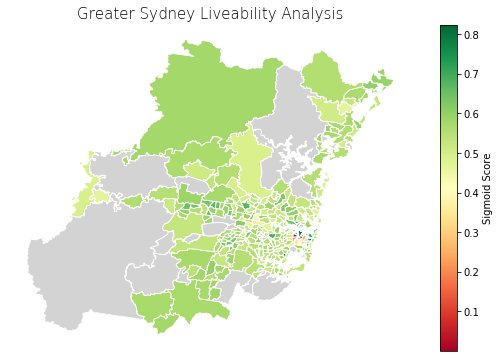

In [52]:
SQL_Query_for_Task2="""
DROP TABLE IF EXISTS task2_results;
CREATE TABLE task2_results
AS

with Health AS 
(SELECT avg(1000.0*bs."health_care_and_social_assistance"/n."population") AS mean,
stddev(1000.0*bs."health_care_and_social_assistance"/n."population") AS sd
FROM businessstats bs, neighbourhood n
WHERE bs."area_id" = n."area_id"),

Retail AS
(SELECT avg(1000.0*bs."retail_trade"/n."population") AS mean,
stddev(1000.0*bs."retail_trade"/n."population") AS sd
FROM businessstats bs, neighbourhood n
WHERE bs."area_id" = n."area_id"),

Accom AS
(SELECT avg(1000.0*bs."accommodation_and_food_services"/n."population") AS mean,
stddev(1000.0*bs."accommodation_and_food_services"/n."population") AS sd
FROM businessstats bs, neighbourhood n
WHERE bs."area_id" = n."area_id"),

Crime AS 
(SELECT AVG(q1) AS mean,
stddev(q1) AS sd
FROM ( SELECT AVG(be."ORIG_FID"*be."Shape_Area"/s."AREASQKM16")as q1
        FROM break_and_enter be join sa2_data s ON
        ST_Intersects(s.geom,be.geom)
        GROUP BY s."SA2_NAME16") a ),
        
Schools AS 
(SELECT AVG(Schools) AS mean,
stddev(Schools) as sd 
FROM (SELECT 1000.0*COUNT(*)/(AVG(n."0-4")+AVG(n."5-9")+AVG(n."10-14")+AVG(n."15-19")) AS Schools
    FROM school_catchments_combined sc, sa2_data s, neighbourhood n
    WHERE ST_Intersects(s.geom,sc.geom)
    AND s."SA2_MAIN16" = n."area_id"
    GROUP BY s."SA2_NAME16" ) b)

SELECT s."SA2_NAME16",

abs((1000.0*AVG(bs."health_care_and_social_assistance")/AVG(n."population"))-AVG(Health.mean))/AVG(Health.sd) AS HZ,

abs((1000.0*AVG(bs."retail_trade")/AVG(n."population"))-AVG(Retail.mean))/AVG(Retail.sd) AS RZ,

abs((1000.0*AVG(bs."accommodation_and_food_services")/AVG(n."population"))-AVG(Accom.mean))/AVG(Accom.sd) AS AZ,

abs((AVG(be."ORIG_FID"*be."Shape_Area"/s."AREASQKM16")-AVG(Crime.mean))/AVG(Crime.sd)) AS CZ,

abs((1000.0*COUNT(*)/(AVG(n."0-4")+AVG(n."5-9")+AVG(n."10-14")+AVG(n."15-19"))-AVG(Schools.mean))/AVG(Schools.sd)) AS SZ,

1/(1+(exp(-((abs((1000.0*AVG(bs."health_care_and_social_assistance")/AVG(n."population"))-AVG(Health.mean))/AVG(Health.sd))
            +(abs((1000.0*AVG(bs."retail_trade")/AVG(n."population"))-AVG(Retail.mean))/AVG(Retail.sd))
            +(abs((1000.0*AVG(bs."accommodation_and_food_services")/AVG(n."population"))-AVG(Accom.mean))/AVG(Accom.sd))
            -(abs((AVG(be."ORIG_FID"*be."Shape_Area"/s."AREASQKM16")-AVG(Crime.mean))/AVG(Crime.sd)))
            +(abs((1000.0*COUNT(*)/(AVG(n."0-4")+AVG(n."5-9")+AVG(n."10-14")+AVG(n."15-19"))-AVG(Schools.mean))/AVG(Schools.sd))))))) AS Sigmoid

FROM sa2_data s, businessstats bs, break_and_enter be, neighbourhood n,school_catchments_combined sc, Health, Retail, Accom, crime, Schools
WHERE s."SA2_MAIN16" = bs."area_id"
AND bs."area_id" = n."area_id"
AND s."SA2_MAIN16" = n."area_id"
AND ST_Intersects(s.geom,be.geom)
AND ST_Intersects(s.geom,sc.geom)
GROUP BY s."SA2_NAME16"
ORDER BY sigmoid desc
;
"""

# Correctly printing the Coloured Map
query(conn,SQL_Query_for_Task2)

task2_results = query(conn,"SELECT * FROM task2_results")

spatial_task2_results = gpd.GeoDataFrame(task2_results)

sa2_data_original = gpd.read_file("SA2_2016_AUST/SA2_2016_AUST.shp")

task2_results_with_Missing_Data = spatial_task2_results.reset_index().merge(sa2_data_original, left_on = 'SA2_NAME16', right_on = 'SA2_NAME16') 

sa2_data_original_Greater_Sydney = sa2_data_original[sa2_data_original['GCC_NAME16']=='Greater Sydney']

df = pd.concat([task2_results_with_Missing_Data.drop(columns=['index', 'hz','rz','az','cz','sz','sigmoid']), sa2_data_original_Greater_Sydney])
gdf4 = df.drop_duplicates(keep=False)

gdf = gpd.GeoDataFrame(task2_results)

merged = gdf.set_index('SA2_NAME16').join(sa2_data_original_Greater_Sydney.set_index('SA2_NAME16'))

merged2 = pd.concat([merged, gdf4], axis=0)

# Visualising the Results on a map
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Greater Sydney Liveability Analysis', fontdict={'fontsize': '15', 'fontweight' : '3'})
# merged2.drop
merged2.drop(merged2.index[0]).plot(column='sigmoid',
            cmap='RdYlGn',
            linewidth=0.9,
            ax=ax,
            edgecolor='1',
            legend=True, 
            legend_kwds={"label": "Sigmoid Score"},
            missing_kwds={"color": "lightgrey"})



The Top 5 places with Highest Liveability Scores are : 

In [53]:
SQL_Query_for_Best_Places="""
SELECT * FROM task2_results
ORDER BY sigmoid DESC
limit(5);
"""
query(conn,SQL_Query_for_Best_Places)

,SA2_NAME16,hz,rz,az,cz,sz,sigmoid
0,Banksmeadow,0.425829,9.460319,9.200746,0.201544,3.983167,1.000000
1,Sydney - Haymarket - The Rocks,1.980091,0.290178,1.007219,1.830518,0.098221,0.824218
2,Bondi Junction - Waverly,1.134065,0.048608,0.027957,0.117664,0.083633,0.764336
3,North Sydney - Lavender Bay,0.927963,0.011003,0.228796,0.105394,0.106286,0.762902
4,Kogarah,0.892925,0.068376,0.069629,0.003605,0.085310,0.752620


The Bottom 5 places with Lowest Liveability Scores are : 

In [54]:
SQL_Query_for_Worst_Places="""
SELECT * FROM task2_results
ORDER BY sigmoid 
limit(5);
"""
query(conn,SQL_Query_for_Worst_Places)

,SA2_NAME16,hz,rz,az,cz,sz,sigmoid
0,Darlinghurst,0.956905,0.041291,0.161466,10.479619,0.059976,0.000095
1,Surry Hills,0.273281,0.031110,0.150860,6.707776,0.077836,0.002077
2,Potts Point - Woolloomooloo,0.019003,0.089364,0.001466,6.019857,0.089022,0.002956
3,Pyrmont - Ultimo,0.000722,0.065426,0.027556,4.331306,0.100736,0.015722
4,Glebe - Forest Lodge,0.088070,0.093299,0.059755,3.696551,0.103614,0.033836


### Distribution of Calculated Score

We can see that the the sigmoid score calculated above is really concentrated within a small range with a few outliers which make the the score distribution chart look like the following : 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4873990b10>]],
      dtype=object)

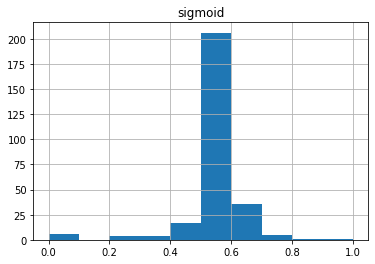

In [55]:
merged2.hist(column='sigmoid')

###  Correlation between the Liveability Score and the Median Rent and Median Income

 We join our results table (table containing zscores and sigmoid score),neighbourhood and sa2 data tables. Then we apply the `corr` function function on `sigmoid` and `avg_monthly_rent` columns. Similarly, we perform this to the `sigmoid` and `median_annual_household_income` columns.

In [56]:
SQL_Query_to_create_task3_data = """
DROP TABLE IF EXISTS task3_data;
CREATE TABLE task3_data AS
select 
"hz", 
"rz", 
"az", 
"cz", 
"sz", 
"sigmoid",
"area_id",
"land_area",
"population",
"number_of_dwellings",
"number_of_businesses",
"median_annual_household_income",
"avg_monthly_rent",
"0-4",
"5-9",
"10-14",
"15-19",
"SA2_MAIN16",
s."SA2_NAME16",
"SA3_NAME16",
"AREASQKM16",
"geom"
from results R, neighbourhood N, sa2_data s
where s."SA2_MAIN16" = N."area_id"
and r."SA2_NAME16"=s."SA2_NAME16"
Order by sigmoid desc;
"""
query(conn,SQL_Query_to_create_task3_data)

SQL_Query_to_find_Correlation = """ SELECT corr("sigmoid","avg_monthly_rent") AS "Rent Correlation",
corr("sigmoid","median_annual_household_income") AS "Income Correlation" FROM task3_data; """
query(conn,SQL_Query_to_find_Correlation)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,Rent Correlation,Income Correlation
0,-0.148096,-0.135192


Results of this analysis points out that there's **no strong linear relationship** between the liveability score and median rent/income of each neighbourhood.

# TASK - 3

In this task we divert our attention to the City of Sydney within the Greater Sydney Area. Here we focus to analyse the suitablity of each suburb within the city of Sydney for our stakeholder, i.e., a family of three with a young child. In addition to health, retail , accommodation, school facilities and concerns about theft for this family we identified safety and recreational facilites are important when settling down in the city.

Therefore we use the [Lights](https://data.cityofsydney.nsw.gov.au/datasets/cityofsydney::lights/about) dataset which gives information about the lights controlled by Sydney City Council and [Playgrounds](https://data.cityofsydney.nsw.gov.au/datasets/cityofsydney::playgrounds/about) dataset which gives data on the playgrounds in the city obtained from the [City of Sydney Open Data Hub](https://data.cityofsydney.nsw.gov.au/).

The modified formula to calculate the liveability for our stake holder is given below.

    Score = Sigmoid (2*(Z_school) + 2*(Z_accomm) + 0.5*(Z_retail) - 3*(Z_crime) + 2*(Z_health) + Z_lights + Z_playgrounds)
                        
In addition to the zscores calculated in task 2 we compute zscores for our Lights and Playgrounds datasets. Higher the number of lights in a suburb higher the safety of the neighbourhood and reduced chances of crime. Also more number of playgrounds implies better recreational facilities. Therefore both these zscores are "added" to the liveability score.

Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.


/opt/jupyterhub/lib/python3.7/site-packages/geopandas/plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


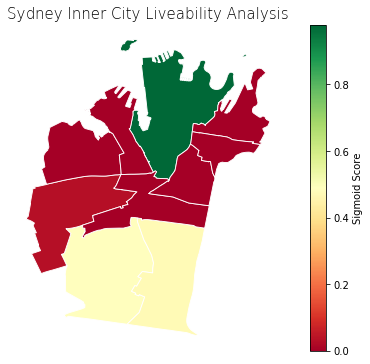

In [57]:
# TASK-3

sql="""
DROP TABLE IF EXISTS Lights_database;
CREATE TABLE Lights_database AS

WITH Lights_data AS 
(SELECT avg(q1) AS mean,
stddev(q1) AS sd
FROM (SELECT COUNT(*) as q1 FROM
    task3_data t, lights l
    where "SA3_NAME16"='Sydney Inner City'
    AND ST_Contains(t.geom,l.geom)
    GROUP BY "SA2_NAME16" ) a)

SELECT t."SA2_NAME16",(abs(COUNT(*)-AVG(ld.mean))/AVG(ld.sd)) AS lz
FROM task3_data t, lights l, lights_data ld
where "SA3_NAME16"='Sydney Inner City'
AND ST_Contains(t.geom,l.geom)
GROUP BY "SA2_NAME16"
;
"""
query(conn,sql)

sql="""
DROP TABLE IF EXISTS Playgrounds_database;
CREATE TABLE Playgrounds_database AS

WITH Playgrounds_data AS 
(SELECT avg(q2) AS mean,
stddev(q2) AS sd
FROM (SELECT COUNT(*) as q2 FROM
    task3_data t, Playgrounds p
    where "SA3_NAME16"='Sydney Inner City'
    AND ST_Contains(t.geom,p.geom)
    GROUP BY "SA2_NAME16" ) a)

SELECT t."SA2_NAME16",(abs(COUNT(*)-AVG(pd.mean))/AVG(pd.sd)) AS pz
FROM task3_data t, playgrounds p, playgrounds_data pd
where "SA3_NAME16"='Sydney Inner City'
AND ST_Contains(t.geom,p.geom)
GROUP BY "SA2_NAME16"
;
"""
query(conn,sql)

sql="""
DROP TABLE IF EXISTS task3_results;
CREATE TABLE task3_results AS

SELECT 
t."SA2_NAME16",
1/(1+(exp(-((2*hz)+(0.5*rz)+(2*az)-(3*cz)+(2*sz)+(lz)+(pz))))) AS Sigmoid,
t.geom

FROM 
task3_data t, lights_database l, playgrounds_database p
WHERE t."SA2_NAME16"=l."SA2_NAME16"
AND p."SA2_NAME16"=l."SA2_NAME16"
ORDER BY Sigmoid desc
"""

# Correctly printing the Coloured Map
query(conn,sql)
results_task3 = query(conn,"SELECT * FROM task3_results")
gdf_task3 = gpd.GeoDataFrame(results_task3)

merged_task3 = gdf_task3.set_index('SA2_NAME16').join(sa2_data_og.set_index('SA2_NAME16'))
merged_task3


fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Sydney Inner City Liveability Analysis', fontdict={'fontsize': '15', 'fontweight' : '3'})

merged_task3.plot(column='sigmoid',
            cmap='RdYlGn',
            linewidth=0.9,
            ax=ax,
            edgecolor='1',
            legend=True, 
            legend_kwds={"label": "Sigmoid Score"},
            missing_kwds={"color": "lightgrey"})

The Liveability Scores for Inner City Sydney are : 

In [58]:
SQL_Query_For_Inner_Sydney = """
SELECT "SA2_NAME16","sigmoid" FROM task3_results
ORDER BY sigmoid DESC;
"""
query(conn,SQL_Query_For_Inner_Sydney)

,SA2_NAME16,sigmoid
0,Sydney - Haymarket - The Rocks,9.792974e-01
1,Erskineville - Alexandria,4.880846e-01
2,Waterloo - Beaconsfield,4.707652e-01
3,Newtown - Camperdown - Darlington,3.322787e-02
4,Redfern - Chippendale,6.804863e-04
5,Glebe - Forest Lodge,9.211143e-05
6,Pyrmont - Ultimo,2.044487e-05
7,Potts Point - Woolloomooloo,4.772905e-08
8,Surry Hills,1.926976e-08
9,Darlinghurst,1.611734e-12


### Distribution of Calculated Score

We can see that the the sigmoid score calculated above is distributed between 3 concentrated areas which make the the score distribution chart look like the following : 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f48740c52d0>]],
      dtype=object)

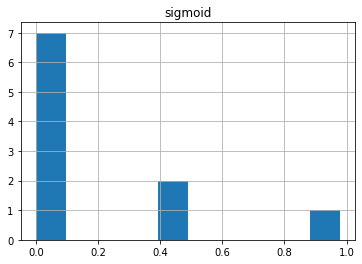

In [59]:
merged_task3.hist(column='sigmoid')

# TASK - 4

We now deploy a t-distributed stochastic neighbor embedding Alogorithm, i.e., an Unsupervised Machine Learning Algorithm to calculate the Liveability Scores for all SA2 areas in Greater Sydney.

Note : The following query may take a long time to process.

In [60]:
merged['cz_neg']=merged['cz']**(-1)
# merged

# Defining Model
model = TSNE(learning_rate=100)

# Fitting Model
transformed = model.fit_transform(merged[['hz','rz','az','cz_neg','sz']])

# Plotting 2d t-Sne
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

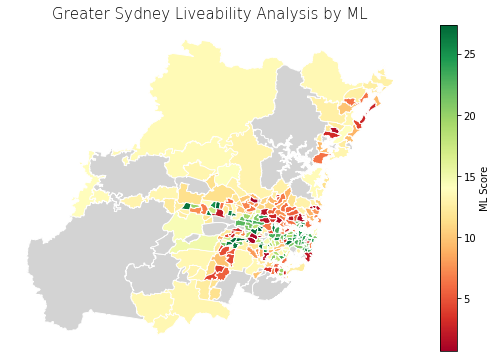

In [61]:
import math
data=[]
ML_merged=merged.copy()
for i in range(len(x_axis)) :
    new_row = math.sqrt(x_axis[i]**2 + y_axis[i]**2)
    data.append([new_row])

ML_df = pd.DataFrame(data,columns=['ML_Score'])
# ML_df
ML_merged = pd.concat([merged.reset_index(), ML_df], axis=1)
ML_merged = pd.concat([ML_merged, gdf4], axis=0)
# ML_merged

fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Greater Sydney Liveability Analysis by ML', fontdict={'fontsize': '15', 'fontweight' : '3'})

ML_merged.drop(0).plot(column='ML_Score',
            cmap='RdYlGn',
            linewidth=0.9,
            ax=ax,
            edgecolor='1',
            legend=True, 
            legend_kwds={"label": "ML Score"},
            missing_kwds={"color": "lightgrey"})

The places with the Highest Liveability Score as per Machine Learning is :

In [32]:
ML_merged.sort_values('ML_Score',ascending=False).drop(0)[['SA2_NAME16','hz','rz','az','cz_neg','sz','sigmoid','ML_Score']][:10]

,SA2_NAME16,hz,rz,az,cz_neg,sz,sigmoid,ML_Score
163,Cabramatta - Lansvale,0.035759,0.056511,0.075869,14.035096,0.093473,0.547447,26.910737
131,Marrickville,0.095663,0.069581,0.062982,14.905780,0.073732,0.558449,26.909639
11,Hassall Grove - Plumpton,0.311396,0.119022,0.150775,15.267982,0.105804,0.650560,26.792327
14,Blacktown (South),0.297904,0.114571,0.123225,22.175700,0.098656,0.643196,26.713448
122,Auburn - Central,0.046286,0.087789,0.099940,14.931467,0.095206,0.565189,26.664821
150,Bankstown - South,0.008031,0.064090,0.080441,23.551181,0.093235,0.550660,26.655740
27,Auburn - North,0.302132,0.053620,0.079958,24.078299,0.105774,0.622448,26.630854
32,Wiley Park,0.253532,0.096291,0.089155,12.888836,0.095606,0.612302,26.625036
22,Cabramatta West - Mount Pritchard,0.242881,0.107096,0.134050,25.074623,0.089957,0.630440,26.581058
79,Neutral Bay - Kirribilli,0.196633,0.079650,0.041086,12.354947,0.097348,0.582678,26.479765


The places with the Lowest Liveability Score as per Machine Learning is :

In [33]:
ML_merged.sort_values('ML_Score').drop(0)[['SA2_NAME16','hz','rz','az','cz_neg','sz','sigmoid','ML_Score']][:10]

,SA2_NAME16,hz,rz,az,cz_neg,sz,sigmoid,ML_Score
104,Rooty Hill - Minchinbury,0.271952,0.103457,0.124496,3.410883,0.091132,0.573919,0.591835
162,Bass Hill - Georges Hall,0.195480,0.097112,0.112475,3.391854,0.080280,0.547487,0.811542
116,Drummoyne - Rodd Point,0.326839,0.074566,0.066116,3.478405,0.094849,0.568291,0.874127
191,Castle Hill - North,0.176891,0.084347,0.083643,3.389971,0.094091,0.535934,0.985465
103,Gosford - Springfield,0.352139,0.068170,0.076281,3.488684,0.088401,0.574039,1.016720
124,Beacon Hill - Narraweena,0.228789,0.100486,0.127050,3.388018,0.097288,0.564257,1.044795
158,Regents Park,0.184699,0.072517,0.141440,3.372570,0.093196,0.548681,1.122873
170,Ermington - Rydalmere,0.235501,0.079697,0.085754,3.491110,0.060113,0.543545,1.347561
55,Hornsby - East,0.427790,0.054155,0.069215,3.542350,0.103392,0.592003,1.373550
145,Chester Hill - Sefton,0.197093,0.082648,0.138806,3.462698,0.074919,0.550990,1.381813


### Distribution of Calculated Score

We can see that the the sigmoid score calculated above is really concentrated within a small range with one outlier. Therefore, we plot the distribution of the scores, omitting the outlier : 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4874216410>]],
      dtype=object)

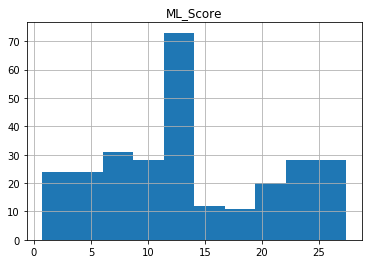

In [62]:
ML_merged.drop(0).hist(column='ML_Score')

## Closing Connections

Now, having completed our analysis, we will close our connection to the PostgreSQL server.

In [63]:
conn.close()
db.dispose()